In [129]:
import tensorflow as tf
import numpy as np
import pathlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image
%matplotlib inline

In [130]:
MODEL_NAME = 'face_detection_graph'
PATH_TO_CKPT = './model/frozen_inference_graph.pb'

In [131]:
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('data/images/test')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))[::25]
TEST_IMAGE_PATHS

[PosixPath('data/images/test/01c96b4b-7440-428f-b39c-f78fee340236.jpg'),
 PosixPath('data/images/test/41330d51-af04-4f5f-8915-c6ab699ea88f.jpg'),
 PosixPath('data/images/test/86f42950-5ca8-47a3-8ac9-fa42d1e77450.jpg'),
 PosixPath('data/images/test/c6e2baf0-38e1-4a9a-b198-d0505921e323.jpg'),
 PosixPath('data/images/test/fa6a4bcc-ddc8-4926-a55b-ce6866e4c93e.jpg')]

In [132]:
# load frozen graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(graph_def, name='')

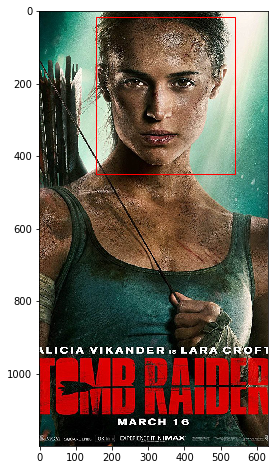

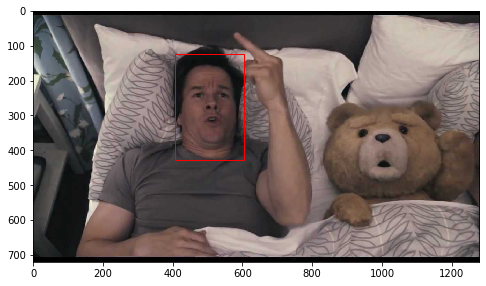

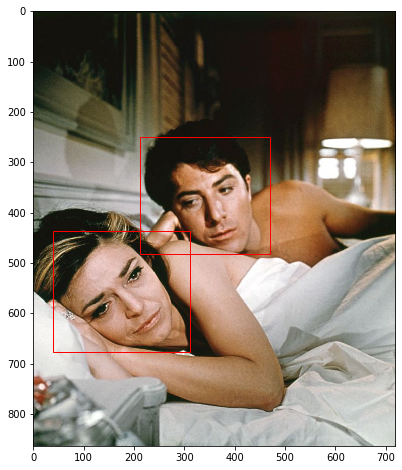

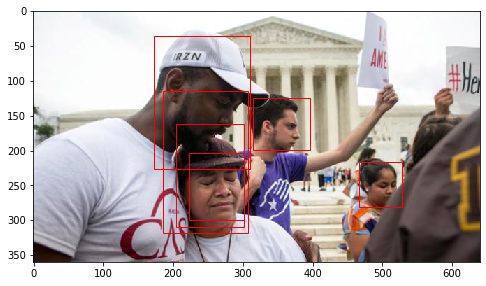

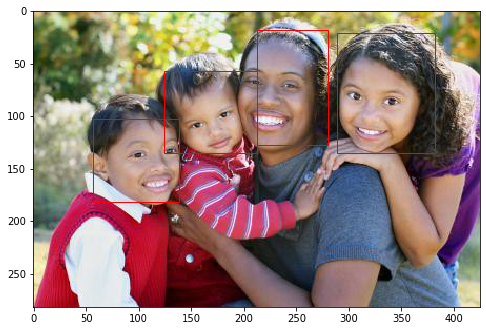

In [133]:
def plot_image_with_boxes(image, boxes, classes, scores, threshhold=0.3):
    width, height = image.size
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()
    for i in range(100):
        if scores[i] <= threshhold:
            break
#         xmin, ymin, xmax, ymax = boxes[i]
        ymin, xmin, ymax, xmax = boxes[i]
        xmin *= width
        xmax *= width
        ymin *= height
        ymax *= height
    
        rect = patches.Rectangle(
            (xmin, ymin), 
            xmax-xmin, 
            ymax-ymin,
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
    plt.show()
        
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for i, img_path in enumerate(TEST_IMAGE_PATHS):
            image = Image.open(img_path)
            image_np = np.asarray(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
            boxes, scores, classes, num_detections = (sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor:image_np_expanded}
            ))
            plot_image_with_boxes(
                image,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
            )